# Purpose

In the previous Notebook, we discussed adding additional data to our customer's shopping behaviours. Specifically, we spoke of adding both time between a game's release and a customer purchase, as well as game description similarity.

This Notebook tackles the former.

In [1]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd  # For processing and IO

import datetime as dt

from sklearn.preprocessing import (
    Normalizer, StandardScaler
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

try:
    from sklearnex import patch_sklearn
    patch_sklearn()
except ImportError:
    pass

from matplotlib import pyplot as plt
%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [30]:
# We initiate random seeds for algorithms
KM_RANDOM_SEED=42
PCA_RANDOM_SEED=7

In [32]:
def try_many_standardisations(column: pd.Series) -> None:
    """
    Plot a number of standardisation and transformations.
    """
    fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(10, 2))
    
    # Plot the original
    column.plot(kind='hist', ax=ax[0], bins=15)
    ax[0].set_title('Original')
    
    # Plot the normalised array
    pd.Series(Normalizer().fit_transform(
        column.values.reshape(-1, 1)
    ).reshape(-1, )).plot(kind='hist', ax=ax[1], bins=15)
    ax[1].set_title('Normalised')
    
    # Plot the logarithmic transformed data
    np.log(
        column[column > 0]
    ).plot(kind='hist', ax=ax[2], bins=15)
    ax[2].set_title('Log (0s removed)')
    
    # Plot the square root transformed data
    np.sqrt(column).plot(kind='hist', ax=ax[3], bins=15)
    ax[3].set_title('Square Root')
    
    # Plot the cube root transformed data
    (column ** (1/3)).plot(kind='hist', ax=ax[4], bins=15)
    ax[4].set_title('Cube Root')
    
    plt.tight_layout()
    

def perform_kmeans(df: pd.DataFrame, n_clusters: int) -> np.array:
    """
    Small helper function to perform KMeans with a set number of
    clusters.
    
    Returns the clusters from KMeans.
    """
    # We create the clusters
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=KM_RANDOM_SEED
    )
    kmeans.fit(df)

    return kmeans.labels_
    

def plot_kmeans(df: pd.DataFrame, ax = None):
    """
    Plots the clusters from k-means (data is reduced to 
    2 dimensions using PCA).
    """
    # We decompose the data
    decomp = PCA(
        2, 
        random_state=PCA_RANDOM_SEED
    ).fit_transform(df)
    
    unique_labels = np.unique(df['cluster'])
    
    if not ax:
        _, ax = plt.subplots()
    for lbl in unique_labels:
        ax.scatter(
            decomp[df['cluster'] == lbl, 0], 
            decomp[df['cluster'] == lbl, 1],
            s=2.5,
            label = f'Cluster {lbl+1}'
        )
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


def analyse_clusters(data: pd.DataFrame) -> pd.DataFrame:
    """
    Analyses the clustered data. Returns agregated dataframe.
    """
    # Averages for each column
    aggr = data.groupby('cluster').mean()
    
    # And the number of members in each cohort
    aggr = pd.concat(
        [
            aggr, 
            data.groupby('cluster').size()
        ], 
        axis=1
    ).rename(columns={0: 'cohort_size'})
    
    return aggr

To find the time between purchase and release, we will assume that a game is release at exactly midnight of it's release date, and we'll build a function that calculates the difference in days between the 2 timestamps (rounded up to days).

In [4]:
# This should be familiar now
# We load the relevant datasets
apps = pd.read_json(
    '../data/processed/apps_with_genresim.json'
)
apps['release_date__dt'] = pd.to_datetime(
    apps['release_date__date'], 
    format='%b %d, %Y',
    utc=True
)

users = pd.read_csv(
    '../data/raw/purchase_data.csv',
    parse_dates=['timestamp_purchased']
)

users_rf = pd.read_json(
    '../data/processed/simple_userRF.json'
)

The `users` dataframe contains information regarding when a purchase was made, and the `apps` dataframe contains the release date for each game. All we need to do is find the number of days from release a purchase was made.

In [7]:
users_apps = users.merge(
    apps,
    on='appid',
)
display(users_apps.sample(5))
print(users_apps.shape)

,userid,appid,timestamp_purchased,name,release_date__date,genre_description,categories_description,short_description,about_the_game,genre_sim_NieR,release_date__dt
120072,9e22851b9a190aa503d1093460d5a5ce4092b562069b96...,6910,2015-10-19 05:40:26.554344+00:00,Deus Ex: Game of the Year Edition,"Mar 29, 2007",Action,"Multi-player,Single-player",None,The year is 2052 and the world is a dangerous ...,0.333333,2007-03-29 00:00:00+00:00
73089,9d71d121a178862f72014a7888f63f6cda864653521e0d...,203160,2015-12-20 17:59:57.554344+00:00,Tomb Raider,"Mar 4, 2013","Action,Adventure","Full controller support,Multi-player,Single-pl...",Tomb Raider explores the intense origin story ...,"<img src=""https://steamcdn-a.akamaihd.net/stea...",0.250000,2013-03-04 00:00:00+00:00
51258,ca7f8fa1d0bae22086b2204ea13fec0b9b824305ff100c...,337000,2016-08-29 02:55:09.554344+00:00,Deus Ex: Mankind Divided™,"Aug 23, 2016","Action,RPG","Full controller support,Single-player,Steam Ac...","Now an experienced covert operative, Adam Jens...","<img src=""https://steamcdn-a.akamaihd.net/stea...",0.666667,2016-08-23 00:00:00+00:00
109227,5a1aa178e997e7dd78c4aa40d92ea3080060680b59f443...,307690,2015-06-12 23:58:54.554344+00:00,Sleeping Dogs: Definitive Edition,"Oct 8, 2014","Action,Adventure,Racing","Full controller support,Single-player,Steam Ac...",The Definitive Edition of the critically accla...,The Definitive Edition of the critically accla...,0.200000,2014-10-08 00:00:00+00:00
96315,d053b99d009ff78427244d5a9c09c2f4076434a28b90ef...,39110,2015-03-21 05:06:54.554344+00:00,SEASON OF MYSTERY: The Cherry Blossom Murders,"Feb 3, 2010",Casual,"Single-player,Steam Achievements",None,\r\n\t\t\t\t\t<p>Your husband Richard lies dea...,0.000000,2010-02-03 00:00:00+00:00


(133525, 11)


We will create a function that finds the day difference between 2 timestamps, and apply it to every row.

In [9]:
def round_time(
    dt1: dt.datetime, 
    dt2: dt.datetime, 
    round_to: str = '1d'
) -> dt.timedelta:
    """
    Returns a rounded timedelta from two datetime objects.
    dt1 and dt2 should be two datetime objects.
    """
    return (dt1 - dt2).round(round_to)

In [11]:
users_apps['time_between_purchase_release'] = users_apps[
    [
        'release_date__dt', 
        'timestamp_purchased'
    ]
].apply(
    lambda dts: round_time(dts[1], dts[0]).days,
    axis=1
)

# We'll correct for the shortcomings of our round_time
# function by replacing values with 0 if the date of purchase
# and the date of release is the same
indeces = users_apps[
    users_apps['release_date__dt'].dt.date == users_apps['timestamp_purchased'].dt.date
].index.tolist()

users_apps.loc[indeces, 'time_between_purchase_release'] = 0

print(
    users_apps['time_between_purchase_release'].min(),
    users_apps['time_between_purchase_release'].max()
)

-1101 4212


Some users having purchased their games before release date means that they were either invited to a alpha or beta release of the game, or that they acquired an early release version of the game (which is the case for, for example, "Black The Fall", which had an early release in 2014, but the release date for home consoles (PS4/Xbox) was on the 11$^{th}$ of July, 2017.

To treat these data, we can either replace all of the negative dates with 0, this way treating every early access user as having bought the game on release. This would cause us to have an increased number of sales for when the game is released, which might not match other internal datasets. We can also remove the users, but we would be losing critical information. We could also keep the range as is, making use of the knowledge that a subset of users will regularly find early release of games.

Let's have a closer look at the new column.

<AxesSubplot:ylabel='Frequency'>

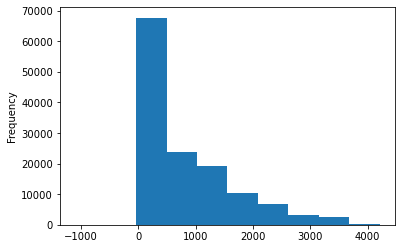

In [14]:
users_apps['time_between_purchase_release'].plot(kind='hist')

Despite the negative time before release, there are still only a fraction of purchases that occur before the release date. We will approach this column the same way we approached the genre similarity: getting an average for each user.

In [20]:
full_data = pd.merge(
    users_apps.groupby(
        'userid',
        as_index=False
    ).aggregate(
        {
            'genre_sim_NieR': np.nanmean,
            'time_between_purchase_release': np.nanmean
        }
    )
    ,
    users_rf,
    on='userid'
)
display(full_data.sample(5))

,userid,genre_sim_NieR,time_between_purchase_release,user_recency,user_frequency_2013,user_frequency_2014,user_frequency_2015,user_frequency_2016
72216,a1f68847d21e57a47d470c8732298fdddefdafe6ad8f01...,0.250000,1383.0,1151,0,1,0,0
20396,2d9318b9a3fa1743420419458eda00f9f172de226eb2e6...,0.250000,666.0,791,0,1,0,0
101113,e236bc92e72d641290e48bc5f047db67be891137cb51fb...,0.333333,1295.0,40,0,0,0,1
53476,7750af273041ff928e5a76d22a13a085eb777de71834e0...,0.250000,1381.0,1153,0,1,0,0
66095,93f82385dd194c81475f00277e7b3d986207cd6b5df255...,0.250000,1134.0,1400,1,0,0,0


And with this, we have added a separate column to our data. We will now preprocess and cluster the rows so see how the new datapoint influences the clustering!

### Preprocessing

We know how to preprocess most of our columns, but not the new one. Let's have a look at how the different transformations affect the data therein.

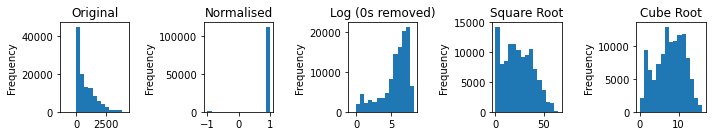

In [24]:
try_many_standardisations(full_data['time_between_purchase_release'])

Based on the visuals, it appears that cube root transformation more closely makes our data resemble a normal distribution.

In [25]:
full_data['user_recency_sr'] = np.sqrt(full_data['user_recency'])
full_data['time_between_purchase_release_cr'] = np.cbrt(
    full_data['time_between_purchase_release']
)

Now we standardise, as we have done before.

In [28]:
scaler = StandardScaler()

full_data_standardised = full_data.copy(deep=True)

cols_to_std = [
    'genre_sim_NieR',
    'user_recency_sr',
    'user_frequency_2013',
    'user_frequency_2014', 
    'user_frequency_2015', 
    'user_frequency_2016',
    'time_between_purchase_release_cr'
]

for col in cols_to_std:
    scaler = StandardScaler()
    full_data_standardised[
        f'{col}_std'
    ] = scaler.fit_transform(
        full_data_standardised[col].values.reshape(-1, 1)
    )

for_kmeans = full_data_standardised.set_index(
    'userid' # we no longer need the userid column, 
).filter(
    regex='_std' # To keep every standardised column
)
display(for_kmeans.head())

,genre_sim_NieR_std,user_recency_sr_std,user_frequency_2013_std,user_frequency_2014_std,user_frequency_2015_std,user_frequency_2016_std,time_between_purchase_release_cr_std
userid,,,,,,,
00002eaf0b53c394391f96a5cae5023ef8ae704797880bb97b1a78eb0c6eb05a,2.368959,-0.943674,-0.319101,-0.550962,-0.523706,0.694216,-1.401068
00015d3d8ae55e47cc0bf2d964ea7f6a3f4ac65239abe280dd1adb8b143e3ff1,-0.403591,1.793497,2.391075,-0.550962,-0.523706,-0.741147,-1.687781
000364b1cefaf76b3abf76080595936a32de847e908ee70cf0ac25cff96b6fe0,2.368959,-0.906819,-0.319101,-0.550962,-0.523706,0.694216,-1.601753
00048a2093a1786989d15a4855ba1c3511c02e4c9210940b1a4fa83b0831c967,-0.403591,-0.264197,-0.319101,-0.550962,-0.523706,0.694216,-1.516236
0004f2043ce240448a1f508cee1413730a207f8dabdd2c10812ca4e32169f01c,2.368959,-0.939533,-0.319101,-0.550962,-0.523706,0.694216,-1.417331


### Clustering

Now we can perform the same steps as we did in the previous Notebook.

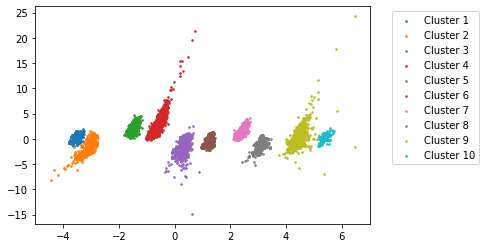

In [33]:
for_kmeans['cluster'] = perform_kmeans(for_kmeans, 10)
plot_kmeans(for_kmeans)

Skipping a few steps, and fixing the number of clusters at 10,

In [35]:
full_data['cluster'] = perform_kmeans(for_kmeans, 10)
analyse_clusters(
    full_data.drop(
        ['user_recency_sr', 'time_between_purchase_release_cr'], 
        axis=1
    )
)

,genre_sim_NieR,time_between_purchase_release,user_recency,user_frequency_2013,user_frequency_2014,user_frequency_2015,user_frequency_2016,cohort_size
cluster,,,,,,,,
0,0.644420,256.980388,167.646504,0.010655,0.033296,0.043285,1.074584,9010
1,0.251764,1290.182714,592.808821,0.002725,0.036816,1.087067,0.043787,15781
2,0.239684,1048.164143,942.224268,0.007491,1.142612,0.032479,0.022701,17488
3,0.260572,173.205460,228.091171,0.007631,0.025322,0.017974,1.063927,17692
4,0.263824,1511.572346,182.368132,0.010717,0.035958,0.043995,1.248884,21275
5,0.322568,1001.438122,343.745030,0.056180,0.342264,3.047537,1.146932,1157
6,0.391152,145.659987,947.664512,0.005251,1.070592,0.039487,0.024540,9902
7,0.273987,663.326807,1165.718805,1.107393,0.082139,0.055662,0.049458,11444
8,0.304173,129.581675,526.800498,0.002369,0.026419,1.056036,0.061012,8441


We now have another metric with which to classify these clusters. We can see that cluster 0 is one of our most valuable clusters (considering the business preposition); customers in this cluster tend to prefer games with similar genres, are often purchasing games closer to release date, and have been active more recently. Customers in cluster 9 are also in a similar bucket, though it is a smaller cluster and they were more active in 2015.

Interestingly, there is a large contigency of customers with relatively low recency statistics, but high time between purchase and release (cluster 4), indicating that a number of our customers buy games a certain period after release. We may attibute this to customers buying games on sale or as part of bundles, though we would need more information to confirm this (i.e. whether the games were on sale when purchases, whether a voucher was used, whether the purchase was par of a bundle, etc...). This may help our marketing efforts; if we know that there is a consistent group of users who purchase games when they are discounted, we can set up marketing emails to let them know a sale is coming up!

---

### Wrap up

In the last 2 Notebooks, we will add to our data how similar games are based on their description. The rationale behind this is more extensively explained in the next Notebook, but in short, games that share the same set of genres might have completely different "feels" (story, atmosphere, gameplay, etc...).